> Parts of this notebook may no longer work with other parts. It also may not be the most up-to-date copy on my machine, since I use it for scratch work.

# Preliminary

In [248]:
### Imports, globals, etc.
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sb
import pandas as pd
import numpy as np
import random
import math
import os
%matplotlib inline

ROOT_DIR = '/home/trevor/Projects/iot-diff/iot-tc/'
DATA_FILE = 'split-dates-features.csv'
DATA_PATH = os.path.join(ROOT_DIR, DATA_FILE)

In [242]:
device_categories = {
    'hub': [
        'd0-52-a8-00-67-5e', 
        '44-65-0d-56-cc-d3'
    ],
    'camera': [
        '70-ee-50-18-34-43',
        'f4-f2-6d-93-51-f1',
        '00-16-6c-ab-6b-88',
        '30-8c-fb-2f-e4-b2',
        '00-62-6e-51-27-2e',
        'e8-ab-fa-19-de-4f',
        '00-24-e4-11-18-a8'
    ],
    'switch': [
        'ec-1a-59-79-f4-89',
        '50-c7-bf-00-56-39',
        '74-c6-3b-29-d7-1d',
        'ec-1a-59-83-28-11'
    ],
    'air_quality': [
        '18-b4-30-25-be-e4',
        '70-ee-50-03-b8-ac'
    ],
    'healthcare': [
        '00-24-e4-1b-6f-96',
        '74-6a-89-00-2e-25',
        '00-24-e4-20-28-c6'
    ],
    'lightbulbs': [
        'd0-73-d5-01-83-08'
    ],
    'electronics': [
        '18-b7-9e-02-20-44',
        'e0-76-d0-33-bb-85',
        '70-5a-0f-e4-9b-c0'
    ],
    'non_iot': [
        '00-24-e4-10-ee-4c',
        '08-21-ef-3b-fc-e3',
        '14-cc-20-51-33-ea',
        '30-8c-fb-b6-ea-45',
        '40-f3-08-ff-1e-da',
        '74-2f-68-81-69-42',
        '8a-05-81-fa-cc-14',
        'ac-bc-32-d4-6f-2f',
        'b4-ce-f6-a7-a3-c2',
        'd0-a6-37-df-a1-e1',
        'd2-13-91-23-2a-58',
        'f4-5c-89-93-cc-85'
    ]
}

device_names = {
    # IoT
    'd0-52-a8-00-67-5e': 'Smart_Things',
    '44-65-0d-56-cc-d3': 'Amazon_Echo',
    '70-ee-50-18-34-43': 'Netatmo_Welcome',
    'f4-f2-6d-93-51-f1': 'TP-Link_Day_Night_Cloud_Camera',
    '00-16-6c-ab-6b-88': 'Samsung_SmartCam',
    '30-8c-fb-2f-e4-b2': 'Dropcam',
    '00-62-6e-51-27-2e': 'Insteon_Camera_wired',
    'e8-ab-fa-19-de-4f': 'Insteon_Camera_wireless',
    '00-24-e4-11-18-a8': 'Withings_Smart_Baby_Monitor',
    'ec-1a-59-79-f4-89': 'Belkin_Wemo_Switch',
    '50-c7-bf-00-56-39': 'TP-Link_Smart_Plug',
    '74-c6-3b-29-d7-1d': 'iHome',
    'ec-1a-59-83-28-11': 'Belkin_Wemo_motion_sensor',
    '18-b4-30-25-be-e4': 'NEST_Protect_smoke_alarm',
    '70-ee-50-03-b8-ac': 'Netatmo_weather_station',
    '00-24-e4-1b-6f-96': 'Withings_smart_scale',
    '74-6a-89-00-2e-25': 'Blipcare_blood_pressure_meter',
    '00-24-e4-20-28-c6': 'Withings_aura_sleep_sensor',
    'd0-73-d5-01-83-08': 'LiFX_Smart_bulb',
    '18-b7-9e-02-20-44': 'Triby_speaker',
    'e0-76-d0-33-bb-85': 'PIX-STAR_photo_frame',
    '70-5a-0f-e4-9b-c0': 'HP_printer',
    # non-IoT
    '00-24-e4-10-ee-4c': 'non-iot_1',
    '08-21-ef-3b-fc-e3': 'non-iot_Smartphone',
    '14-cc-20-51-33-ea': 'non-iot_Laptop',
    '30-8c-fb-b6-ea-45': 'non-iot_2',
    '40-f3-08-ff-1e-da': 'non-iot_3',
    '74-2f-68-81-69-42': 'non-iot_4',
    '8a-05-81-fa-cc-14': 'non-iot_5',
    'ac-bc-32-d4-6f-2f': 'non-iot_6',
    'b4-ce-f6-a7-a3-c2': 'non-iot_7',
    'd0-a6-37-df-a1-e1': 'non-iot_8',
    'd2-13-91-23-2a-58': 'non-iot_9',
    'f4-5c-89-93-cc-85': 'non-iot_10'
}

def assign_category(device):
    for k, v in device_categories.items():
        if device in v:
            return k
    print('Warning: no category found for device "{}"'.format(device))
    return 'no_category_found'

def is_iot(device):
    iot_cats = {x:device_categories[x] for x in device_categories if x!='non_iot'}
    return any(device in l for l in iot_cats.values())

def mac_to_name(mac):
    return device_names[mac]

In [243]:
df = pd.read_csv(DATA_PATH)

# Drop NaN values
df.fillna(df.groupby('device').mean(), inplace=True)
df.fillna(df.mean(), inplace=True)

# Add device categories
df['device_category'] = df.apply(lambda row: assign_category(row['device']), axis=1)

# Training

In [319]:
# Erman's semi-supervised algorithm
# NOTE: Do we need to use their features?
# NOTE: Do we need to use flow statistics?
# TODO: Worth trying the real-time version?
def ermans(df, num_labeled=80, k=200):
    """An implementation of Erman's semi-supervised algorithm.

    Args:
        df (pandas.DataFrame): DataFrame with instances
        num_labeled (int): How many random instances from `data` should retain 
                      their labels. The remaining `len(data)-num_labeled`
                      instances will be treated as if they were unlabeled.
        k (int): Value of `k` for k-means

    Returns:
        A scaled version of `df` with cluster and classification
    """
    # Preliminary: Scale the data and split it
    # TODO: Do they mention scaling in the paper?
    scaled_df = df.copy()
    features = scaled_df.columns[2:-1]
    scaled_df[features] = StandardScaler().fit_transform(scaled_df[features])
    scaled_df['is_labeled'] = False
    label_indices = np.random.choice(df.index, num_labeled)
    scaled_df.loc[label_indices, 'is_labeled'] = True

    # Step 1: k-means
    kmeans = KMeans(n_clusters=k).fit(scaled_df[features])
    scaled_df['cluster'] = kmeans.labels_
    
    # Step 2: Mapping
    # TODO: Find a cleaner way to do it
    for i in range(k):
        cluster_labeled = scaled_df[(scaled_df['cluster']==i) & (scaled_df['is_labeled'])]
        if len(cluster_labeled) == 0:
            classification = 'unknown'
        else:
            classification = cluster_labeled['device_category'].value_counts().idxmax()
        scaled_df.loc[(scaled_df['cluster']==i), 'classification'] = classification
    return scaled_df
    
result_df = ermans(df, num_labeled=20, k=10)
print(result_df['classification'].value_counts())
x = result_df[result_df['classification']!='unknown']
(x['device_category'] == x['classification']).value_counts()

camera        335
unknown        42
non_iot        27
healthcare     16
Name: classification, dtype: int64


False    240
True     138
dtype: int64

In [35]:
train = df[df['date']<='16-10-06']
test = df[df['date']>'16-10-06']

clf = RandomForestClassifier()
clf.fit(train[train.columns[2:-1]], train['device_category']!='non_iot')
clf.score(test[test.columns[2:-1]], test['device_category']!='non_iot')

0.99122807017543857

In [359]:
# IoT v. non-IoT
# [AAA]
clf = RandomForestClassifier()
clf.fit(df[df.columns[2:-1]], df['device_category']!='non_iot')
[print(c+': {0:.3f}'.format(i)) for c, i in zip(df.columns[2:-1], clf.feature_importances_)]

sleep_time: 0.025
active_volume: 0.115
avg_packet_size: 0.050
mean_rate: 0.145
peak_to_mean_rate: 0.038
active_time: 0.062
num_servers: 0.200
num_protocols: 0.286
unique_dns_reqs: 0.035
dns_interval: 0.022
ntp_interval: 0.022


[None, None, None, None, None, None, None, None, None, None, None]

In [371]:
# IoT v. non-IoT
# [AAB]
clf = RandomForestClassifier(criterion='entropy')
clf.fit(df[df.columns[2:-1]], df['device_category']!='non_iot')
[print(c+': {0:.3f}'.format(i)) for c, i in zip(df.columns[2:-1], clf.feature_importances_)]

sleep_time: 0.039
active_volume: 0.053
avg_packet_size: 0.080
mean_rate: 0.052
peak_to_mean_rate: 0.049
active_time: 0.059
num_servers: 0.281
num_protocols: 0.190
unique_dns_reqs: 0.113
dns_interval: 0.053
ntp_interval: 0.030


[None, None, None, None, None, None, None, None, None, None, None]

Explained variance ratio cumulative sums: 
Comp.1: 0.25779748578
Comp.2: 0.398592877907
Comp.3: 0.529512272025
Comp.4: 0.630625671711
Comp.5: 0.720398636861
Comp.6: 0.797121444577
Comp.7: 0.851829958451
Comp.8: 0.903381694699
Comp.9: 0.947049396473
Comp.10: 0.980170988129
Comp.11: 1.0


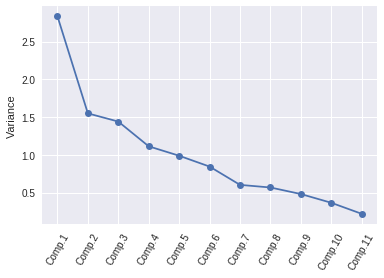

In [141]:
# PCA elbow
scaled = StandardScaler().fit_transform(df[df.columns[2:-1]].sample(frac=1))
pca = PCA().fit(scaled)
y = np.std(pca.transform(scaled), axis=0)**2
x = np.arange(len(y)) + 1
plt.plot(x, y, 'o-')
plt.xticks(x,['Comp.'+str(i) for i in x], rotation=60)
plt.ylabel('Variance')
var_cumsum = pca.explained_variance_ratio_.cumsum()
print('Explained variance ratio cumulative sums: ')
for i, c in enumerate(var_cumsum):
    print('Comp.'+str(i+1)+': '+str(c))

,centroid,inertia,k
0,"[[0.00920455334274, -0.094528355103, -0.103304...",3760.987443,2
1,"[[-0.220207975128, 1.34883811732, 2.6135111516...",3273.114983,3
2,"[[-0.197574902671, -0.101408200121, -0.2321219...",2765.599497,4
3,"[[2.23169989055, -0.0885021017975, -0.18680409...",2383.170526,5
4,"[[-0.232910658597, 6.38844005394, 1.3372412020...",2044.970200,6
5,"[[-0.225187201074, 0.31379797944, 2.6136132992...",1741.101146,7
6,"[[-0.194345045827, -0.0984588486589, -0.282208...",1475.549539,8
7,"[[3.15227832159, -0.0792668239946, 0.023218811...",1264.266201,9
8,"[[-0.224478407005, -0.0342646462958, 1.2886956...",1040.677725,10
9,"[[-0.198590264849, -0.109474934096, -0.2995435...",916.648992,11


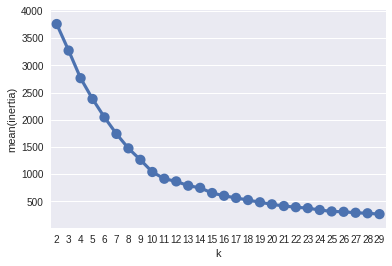

In [144]:
# k-means elbow
low = 2
high = 30

scaled = StandardScaler().fit_transform(df[df.columns[2:-1]].sample(frac=1))
pca = scaled#PCA(n_components=8).fit_transform(scaled)

K = range(low, high)
KM = [KMeans(n_clusters=k).fit(pca) for k in K]
data = [{'centroid':km.cluster_centers_, 'inertia':km.inertia_} for km in KM]
km_df = pd.DataFrame(data)
km_df['k'] = km_df.index+low

sb.pointplot(data=km_df, x='k', y='inertia')
km_df

In [82]:
# Try removing each device from the training data and testing on it
def cycle_remove_devices(data, device_categories):
    bags = []
    prob_preds = []
    for c, ds in device_categories.items():
        for d in ds:
            # Train/test split
            train = data[data['device']!=d]
            test = data[data['device']==d]
            # Train
            features = df.columns[2:-1]
            clf = RandomForestClassifier()
            clf.fit(train[features], train['device_category'])
            # Test
            ps = clf.predict(test[features])
            gt = assign_category(d)
            bags.insert(0, {
                'device': mac_to_name(d),
                'ground_truth': gt,
                'accuracy': len([p for p in ps if p==gt])/len(ps),
                'consensus': Counter(ps).most_common(1)[0][0]
            })
            for row in clf.predict_proba(test[features]):
                dev_dict = dict(zip(clf.classes_, row))
                dev_dict['device'] = d
                dev_dict['ground_truth'] = c
                prob_preds.insert(0, dev_dict)
    return bags, prob_preds
            
bags, prob_preds = cycle_remove_devices(df, device_categories)

bag_cols = ['device', 'ground_truth', 'consensus', 'accuracy']
bag_df = pd.DataFrame(bags)[bag_cols].sort_values(by='accuracy').reset_index(drop=True)

prob_cols = ['device', 'ground_truth', 'hub', 'camera', 'switch', 
             'air_quality', 'healthcare', 'lightbulbs', 'electronics',
             'non_iot']
prob_df = pd.DataFrame(prob_preds)[prob_cols].sort_values(by=['ground_truth', 'device']).reset_index(drop=True)

bag_df.round(decimals=3)

,device,ground_truth,consensus,accuracy
0,Withings_aura_sleep_sensor,healthcare,camera,0.000
1,TP-Link_Day_Night_Cloud_Camera,camera,switch,0.000
2,non-iot_8,non_iot,switch,0.000
3,Dropcam,camera,healthcare,0.000
4,Withings_Smart_Baby_Monitor,camera,healthcare,0.000
5,NEST_Protect_smoke_alarm,air_quality,healthcare,0.000
6,non-iot_2,non_iot,air_quality,0.000
7,Netatmo_weather_station,air_quality,electronics,0.000
8,non-iot_1,non_iot,camera,0.000
9,HP_printer,electronics,switch,0.000


In [59]:
# Try removing each device from the training data and testing on it
# Classifier just does IoT v. non-IoT
def cycle_remove_devices_binary(data, device_categories):
    bags = []
    prob_preds = []
    for c, ds in device_categories.items():
        for d in ds:
            # Train/test split
            train = data[data['device']!=d]
            test = data[data['device']==d]
            # Train
            features = df.columns[2:-1]
            clf = RandomForestClassifier()
            y = train['device_category']!='non_iot'
            clf.fit(train[features], y)
            # Test
            ps = clf.predict(test[features])
            gt = assign_category(d)
            bags.insert(0, {
                'device': mac_to_name(d),
                'ground_truth': gt,
                'accuracy': clf.score(test[features], test['device_category']!='non_iot'),
                'consensus': Counter(ps).most_common(1)[0][0]
            })
            for row in clf.predict_proba(test[features]):
                dev_dict = dict(zip(clf.classes_, row))
                dev_dict['device'] = d
                dev_dict['ground_truth'] = c
                prob_preds.insert(0, dev_dict)
    return bags, prob_preds
            
bin_bags, bin_prob_preds = cycle_remove_devices_binary(df, device_categories)

bin_bag_cols = ['device', 'ground_truth', 'consensus', 'accuracy']
bin_bag_df = pd.DataFrame(bin_bags)[bag_cols].sort_values(by='accuracy').reset_index(drop=True)

bin_prob_df = pd.DataFrame(bin_prob_preds).sort_values(by=['ground_truth', 'device']).reset_index(drop=True)
bin_prob_cols = ['device', 'ground_truth', True, False]
bin_prob_df = bin_prob_df[bin_prob_cols]

#bin_bag_df.round(decimals=3)

In [66]:
# Randomly remove 30% of device categories (i.e. 7 devices) from the 
# training set then test on them
def holdout(data, device_names, n=10):
    runs = []
    for i in range(n):
        # Train/test split
        holdout_devices = random.sample(list(device_names.keys()), 7)
        train = data[~data['device'].isin(holdout_devices)]
        test = data[data['device'].isin(holdout_devices)]
        # Train
        features = df.columns[2:-1]
        clf = RandomForestClassifier()
        clf.fit(train[features], train['device_category'])
        # Test
        score = clf.score(test[features], test['device_category'])
        runs.insert(0, {
            'devices': holdout_devices,
            'accuracy': score
        })
    return runs
        
holdout_df = pd.DataFrame(holdout(df, device_names))
holdout_df['devices'] = holdout_df['devices'].apply(lambda d: [mac_to_name(x) for x in d])
holdout_df[['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7']] = pd.DataFrame([x for x in holdout_df.devices])
holdout_df = holdout_df.drop('devices', axis=1)

In [75]:
# Randomly remove 30% of device categories (i.e. 7 devices) from the 
# training set then test IoT v. non-IoT on them
def holdout_binary(data, device_names, n=10000):
    runs = []
    for i in range(n):
        # Train/test split
        holdout_devices = random.sample(list(device_names.keys()), 7)
        train = data[~data['device'].isin(holdout_devices)]
        test = data[data['device'].isin(holdout_devices)]
        # Train
        features = df.columns[2:-1]
        clf = RandomForestClassifier()
        clf.fit(train[features], train['device_category']!='non_iot')
        # Test
        score = clf.score(test[features], test['device_category']!='non_iot')
        runs.insert(0, {
            'devices': holdout_devices,
            'accuracy': score
        })
    return runs
        
bin_holdout_df = pd.DataFrame(holdout_binary(df, device_names))
bin_holdout_df['devices'] = bin_holdout_df['devices'].apply(lambda d: [mac_to_name(x) for x in d])
bin_holdout_df[['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7']] = pd.DataFrame([x for x in bin_holdout_df.devices])
bin_holdout_df = bin_holdout_df.drop('devices', axis=1)

# Visualizations

/home/trevor/Software/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1903: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/home/trevor/Software/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1904: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc
/home/trevor/Software/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/home/trevor/Software/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


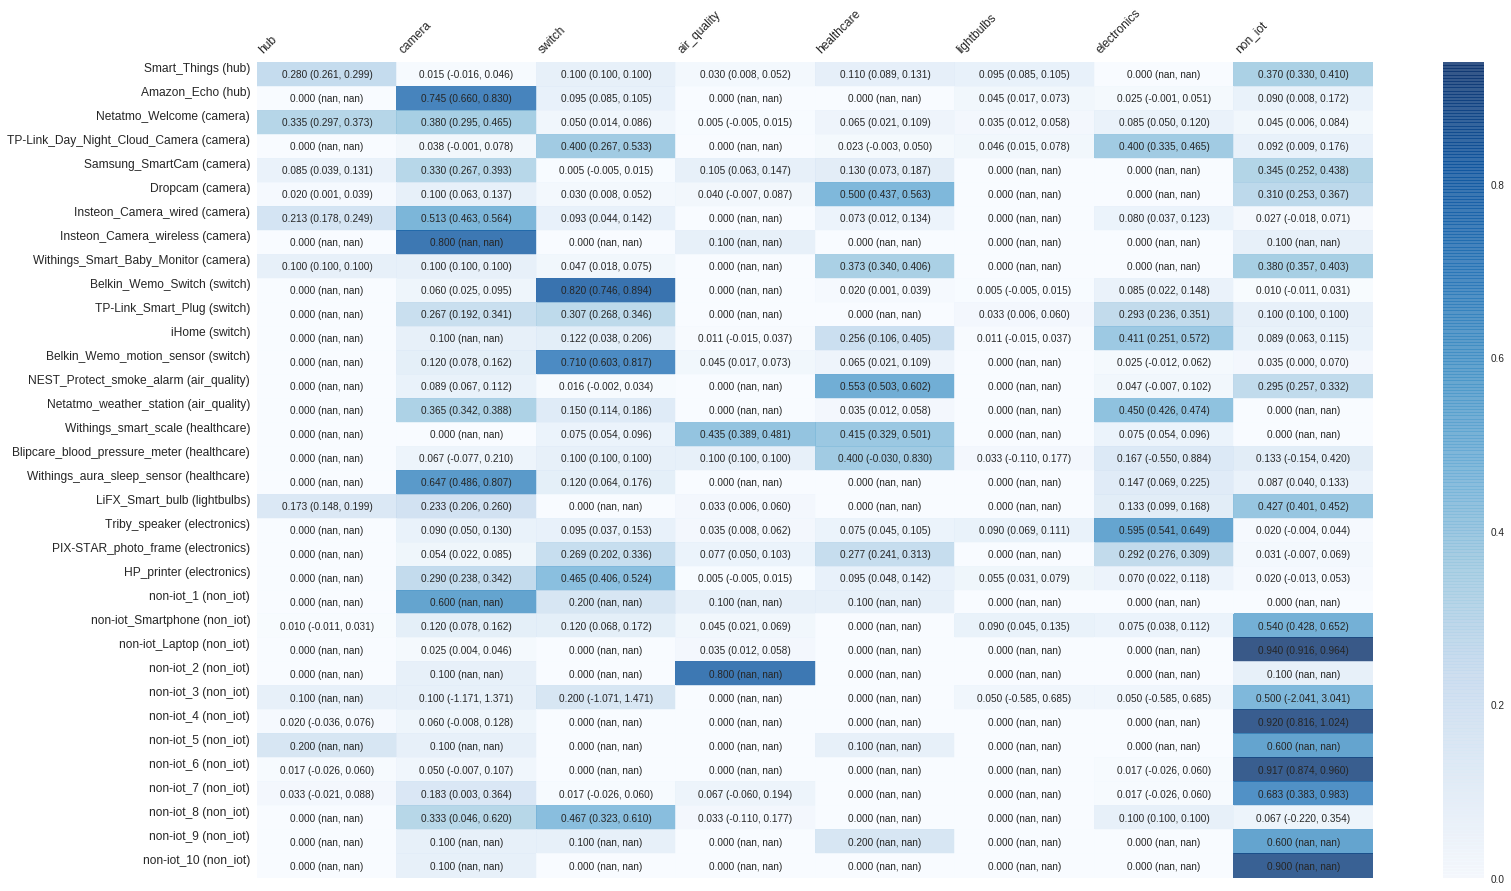

In [106]:
fig, ax = plt.subplots()

ft_cycle_df = prob_df.groupby('device').mean().fillna(0)
#ft_cycle_df = bin_prob_df.groupby('device').mean().fillna(0)
index_order = list(device_names.keys())
ft_cycle_df = ft_cycle_df.reindex(index_order)
heatmap = ax.pcolor(ft_cycle_df, cmap=plt.cm.Blues, alpha=0.8)
plt.colorbar(heatmap)

# Compute 95% CIs
cis = []
for d in ft_cycle_df.index:
    prob_vals = prob_df.fillna(0)[prob_df['device']==d]
    prob_vals = prob_vals[prob_vals.columns[2:]].values
    ci = []
    for col in prob_vals.T:
        col_ci = st.t.interval(0.95, len(col)-1, loc=np.mean(col), scale=st.sem(col))
        x = len(ci)
        ci.append(col_ci)
    cis.append(ci)

data = ft_cycle_df.values
for y in range(data.shape[0]):
    for x in range(data.shape[1]):
        plt.text(x+0.5, y+0.5, '{0:.3f} ({1:.3f}, {2:.3f})'.format(data[y][x], cis[y][x][0], cis[y][x][1]), 
                 ha='center', va='center', size=10)
        
##data = ft_cycle_df.values
##jfor y in range(data.shape[0]):
##j    for x in range(data.shape[1]):
##j        plt.text(x+0.5, y+0.5, '{0:.3f}'.format(data[y][x]), 
##j                 ha='center', va='center', size=10)

fig = plt.gcf()
fig.set_size_inches(25, 15)

ax.set_frame_on(False)
ax.set_yticks(np.arange(ft_cycle_df.shape[0] + 0.5), minor=False)
ax.set_xticks(np.arange(ft_cycle_df.shape[1] + 0.5), minor=False)

ax.invert_yaxis()
ax.xaxis.tick_top()

xlabels = ft_cycle_df.columns #['is_iot' if x else 'not_iot' for x in ft_cycle_df.columns]
ylabels = [mac_to_name(d)+' ('+assign_category(d)+')' for d in ft_cycle_df.index]
ax.set_xticklabels(xlabels, fontsize=12, va='bottom', ha='left', rotation=45)
ax.set_yticklabels(ylabels, fontsize=12, va='top')
pass
plt.savefig('vis/device_probs_95_ci.png', bbox_inches='tight')

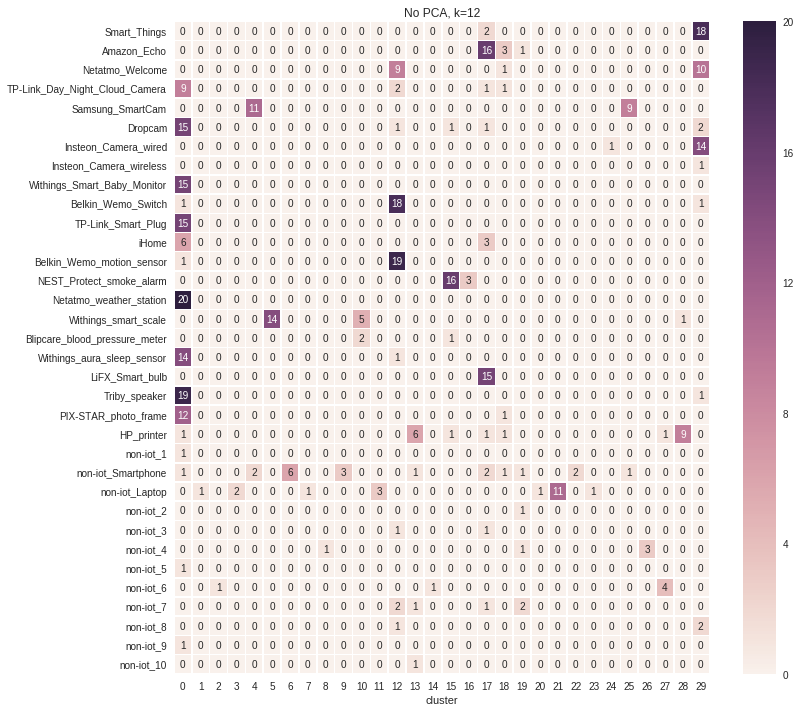

In [302]:
# k-means
features = df.columns[2:-1]
df2 = df.copy().sample(frac=1)
scaled = StandardScaler().fit_transform(df2[features])
#pca = PCA(n_components=8).fit_transform(scaled)
kmeans = KMeans(n_clusters=30).fit(scaled)

df2['cluster'] = kmeans.labels_

df3 = df2.copy()
df2 = df2.pivot_table(index='device', columns='cluster', aggfunc=len, fill_value=0)
df2.index = [mac_to_name(x) for x in df2.index]
df2 = df2.reindex(list(device_names.values()))

fig, ax = plt.subplots(figsize=(12,12))
heatmap = sb.heatmap(df2['date'], annot=True, linewidths=0.5, fmt='d', ax=ax)
plt.title('No PCA, k=12')

In [271]:
df3

,device,date,sleep_time,active_volume,avg_packet_size,mean_rate,peak_to_mean_rate,active_time,num_servers,num_protocols,unique_dns_reqs,dns_interval,ntp_interval,device_category,cluster
30,18-b7-9e-02-20-44,16-09-23,22.342900,3.449930e+02,97.07,10.07,878.59000,4.063590,13,8,2.000000,8.674346e+06,6186.848853,electronics,0
277,70-5a-0f-e4-9b-c0,16-10-05,11.598300,1.366430e+04,704.64,485.51,1692.55000,5.780960,30,37,8.000000,8.529865e+06,3873.820755,electronics,9
154,50-c7-bf-00-56-39,16-10-01,73.957200,3.679480e+02,112.31,3.67,615.24100,3.901390,25,5,2.000000,2.837173e+07,3605.418445,switch,0
308,d0-52-a8-00-67-5e,16-10-07,4.098690,1.898580e+02,56.95,19.80,21.59430,4.051380,66,5,2.000000,1.017824e+07,595.294777,hub,0
108,00-24-e4-1b-6f-96,16-10-01,1867.000000,1.611200e+04,196.74,1.28,1558.55000,18.750000,6,5,2.000000,7.376484e+08,3873.820755,healthcare,2
223,00-24-e4-1b-6f-96,16-10-03,2290.770000,3.237300e+04,199.48,1.28,1704.15000,30.000000,6,5,2.000000,7.377492e+08,3873.820755,healthcare,2
249,18-b4-30-25-be-e4,16-10-04,3539.650000,1.818700e+04,202.57,0.91,2834.05000,16.000000,14,9,2.000000,2.951128e+08,3873.820755,air_quality,2
148,44-65-0d-56-cc-d3,16-09-30,3.951640,8.024900e+02,105.88,68.74,846.01300,5.037570,34,10,4.000000,7.507602e+05,88.826007,hub,0
165,70-ee-50-03-b8-ac,16-10-02,17.798500,1.520480e+03,138.24,23.52,38.10350,9.321850,18,5,2.000000,5.195116e+06,3873.820755,air_quality,0
95,00-16-6c-ab-6b-88,16-09-28,5.348860,2.714720e+03,242.39,201.71,486.21800,4.836090,40,50,4.000000,6.515332e+05,19528.025037,camera,4


In [78]:
# k-means with k=2-30
scaled = StandardScaler().fit_transform(df[df.columns[2:-1]].sample(frac=1))
for i in range(29):
    kmeans = KMeans(n_clusters=i+2).fit(scaled)
    df2 = df.copy()
    df2['cluster'] = kmeans.labels_
    df2 = df2.pivot_table(index='device', columns='cluster', aggfunc=len, fill_value=0)
    df2.index = [mac_to_name(x) for x in df2.index]
    df2 = df2.reindex(list(device_names.values()))
    fig, ax = plt.subplots(figsize=(10+i,12))
    heatmap = sb.heatmap(df2['date'], annot=True, linewidths=0.5, fmt='d', ax=ax)
    heatmap.get_figure().savefig('vis/revised-classes/kmeans_'+str(i+2)+'.png', bbox_inches='tight')
    plt.close(fig)

In [79]:
# k-means for each day
dates_df = df.groupby(by='date')
for date_df in dates_df:
    date = date_df[0]
    date_df = date_df[1]
    scaled = StandardScaler().fit_transform(date_df[date_df.columns[2:-1]].sample(frac=1))
    kmeans = KMeans(n_clusters=8).fit(scaled)
    df2 = df[df['date']==date].copy()
    df2['cluster'] = kmeans.labels_
    df2 = df2.pivot_table(index='device', columns='cluster', aggfunc=len, fill_value=0)
    df2.index = [mac_to_name(x) for x in df2.index]
    df2 = df2.reindex(list(device_names.values()))
    fig, ax = plt.subplots(figsize=(10,12))
    heatmap = sb.heatmap(df2['date'], annot=True, linewidths=0.5, ax=ax)
    heatmap.get_figure().savefig('vis/kmeans-dates/kmeans_date_'+date+'.png', bbox_inches='tight')
    plt.close(fig)

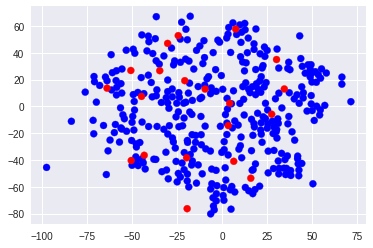

In [176]:
colors = df['device_category']=='non_iot'
colors = colors.apply(lambda x: 'red' if x else 'blue')

tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=30)
y = tsne.fit_transform(scaled)
plt.figure()
plt.scatter(y.T[0], y.T[1], c=colors)

Median: 0.915
Mean: 0.877
Std Dev: 0.112


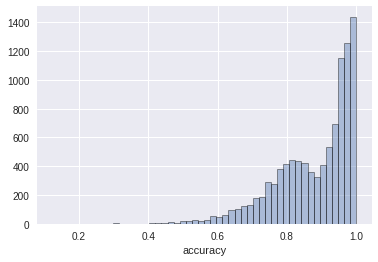

In [76]:
print('Median: {:.3f}'.format(bin_holdout_df['accuracy'].median()))
print('Mean: {:.3f}'.format(bin_holdout_df['accuracy'].mean()))
print('Std Dev: {:.3f}'.format(bin_holdout_df['accuracy'].std()))
sb.distplot(bin_holdout_df['accuracy'], 
            kde=False,
            norm_hist=False,
            hist_kws={'edgecolor':'k', 'linewidth':1})
pass

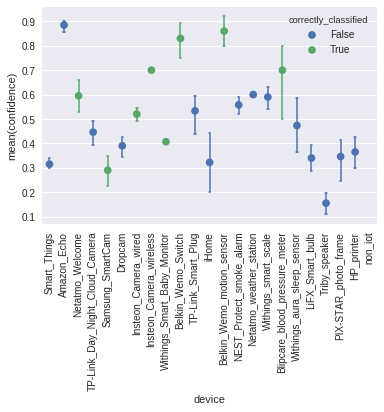

In [118]:
bar_df = pd.melt(prob_df, id_vars=['device', 'ground_truth'],
                 var_name='category', value_name='confidence')
bar_df['device'] = bar_df['device'].apply(mac_to_name)
consensi = bag_df.set_index('device')['consensus']
bar_df['consensus'] = bar_df['device'].apply(lambda x: consensi[x])
bar_df = bar_df[(bar_df['category']==bar_df['consensus'])]#&(bar_df['ground_truth']!=bar_df['consensus'])]
bar_df['correctly_classified'] = bar_df['ground_truth']==bar_df['consensus']

fig = sb.pointplot(x='device', y='confidence', 
                   order=list(device_names.values()), 
                   hue='correctly_classified', data=bar_df, 
                   join=False, errwidth=1.5, capsize=0.1, scale=0.75)
for l in fig.get_xticklabels():
    l.set_rotation(90)

(0.0, 1.025)

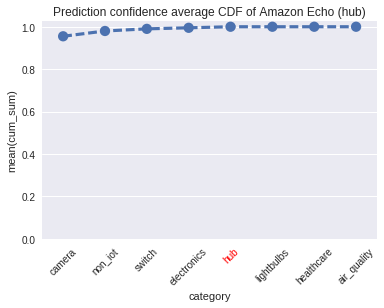

In [110]:
mac = '44-65-0d-56-cc-d3' # Amazon Echo
conf_df = prob_df[prob_df['device']==mac].mean().sort_values()[::-1].cumsum()
conf_df = conf_df.to_frame().reset_index(level=0)
conf_df.columns = ['category', 'cum_sum']
pp = sb.pointplot(x='category',
                  y='cum_sum',
                  data=conf_df,
                  markers=['o'],
                  linestyles=['--'])
for x in pp.get_xticklabels():
    x.set_rotation(45)
    if x.get_text() == 'hub':
        x.set_color('red')
pp.set_title('Prediction confidence average CDF of Amazon Echo (hub)')
plt.ylim(0., 1.025)

In [6]:
# Train
features = df.columns[2:-1]
clf = RandomForestClassifier()
y = train['device_category']
clf.fit(train[features], y.values.ravel())

NameError: name 'train' is not defined

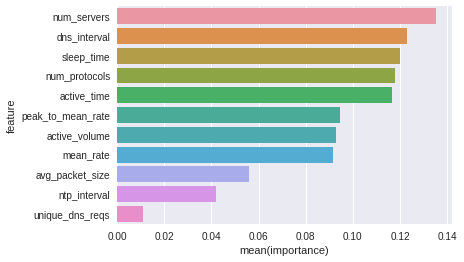

In [169]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

imp_df = pd.DataFrame()
imp_df['importance'] = importances[indices]
imp_df['feature'] = features.values[indices]
import seaborn as sb
%matplotlib inline
sb.barplot(y='feature', x='importance', data=imp_df, orient='h')

(0.0, 1.025)

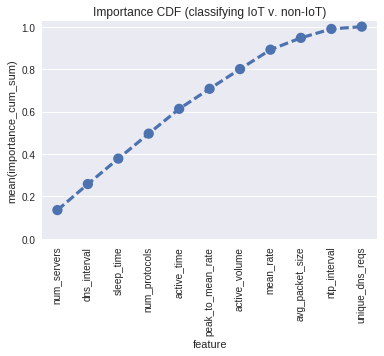

In [170]:
import matplotlib.pyplot as plt

imp_df['importance_cum_sum'] = imp_df.importance.cumsum()
pp = sb.pointplot(x='feature', 
                  y='importance_cum_sum', 
                  data=imp_df,
                  markers=['o'],
                  linestyles=['--'])
for x in pp.get_xticklabels():
    x.set_rotation(90)
pp.set_title('Importance CDF (classifying IoT v. non-IoT)')
plt.ylim(0., 1.025)

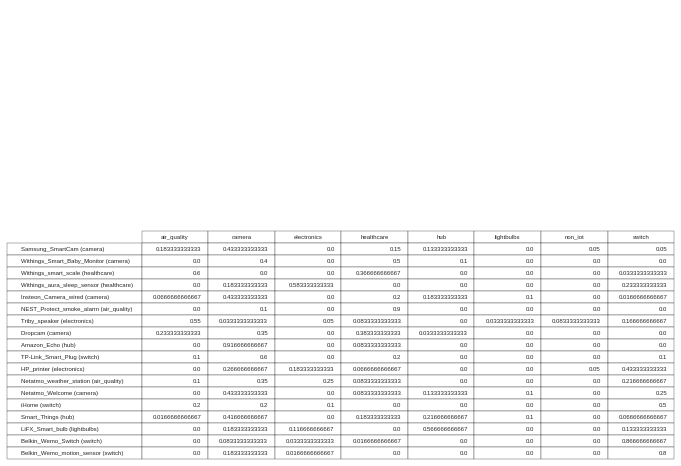

In [212]:
plt.figure(figsize=(21,14))
ax = plt.subplot(321, frame_on=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ylabels = [mac_to_name(d)+' ('+assign_category(d)+')' for d in ft_cycle_df.index]
fig = pd.tools.plotting.table(ax, ft_cycle_df, rowLabels=ylabels)
plt.savefig('fig.png', dpi=300)